In [1]:
import cv2
import numpy as np
import pandas as pd
import csv

import matplotlib.pyplot as plt
%matplotlib inline

import os 
import random
random.seed(200)

from sklearn.model_selection import train_test_split

In [2]:
# get data from Ordner
base_path = os.getcwd() # Verkehrszeichenerkennung/Daten/Final_Training/Images
path_to_sign_data = os.path.join(base_path,'../Daten/Final_Training/Images')
pfad_beschreibung =  os.path.join(base_path, '../Daten/utils/Text_Beschreibung.csv')

In [3]:
#Lies die Beschreibung von Klasse
classe_label = pd.read_csv(pfad_beschreibung)
classe_label = classe_label.set_index('ClassId').T.to_dict()
print(classe_label[2]['SignName'])

Zulässige Höchstgeschwindigkeit (50 km/h)


In [4]:
# Bilder und laben werden eingelesen
images = []
labels = []
for c in range(0, len(classe_label)):
    #  build the path to subdirectory eg. 00000 00001
    prefix = path_to_sign_data + '/' + format(c, '05d') + '/'
    file_path = prefix + 'GT-' + format(c, '05d') + '.csv'
    with open(file_path, 'r') as gt_file:
        gt_reader = csv.reader(gt_file, delimiter=';')
        #  header skipt of csv-files
        next(gt_reader)
        count_row = 0
        for row in gt_reader:
            count_row +=1
            images.append(plt.imread(prefix + row[0]))
            labels.append(int(row[7]))
            if count_row == 50:
                break
print(len(images))
print(len(labels))

2150
2150


In [5]:
  # show image
def show_image (list_image, list_label):
    fig=plt.figure(figsize=(4, 4))
    columns = round(len(list_image)/2)
    rows = round(len(list_image)/2)
    count = 1
    for img,label in zip(list_image, list_label):
        fig.add_subplot(rows, columns,count)
        real_label = classe_label[label]['SignName']
        real_label = real_label.replace(" ", "\n")
        plt.title(real_label)
        plt.imshow(img)  
        count +=1
    plt.show()

In [6]:
# image preprocessing 
IMG_SIZE = 224
batch_size = 64
def preprocessing (list_image):
    list_image_preprocessed = []
    for image in list_image:
        list_image_preprocessed.append(cv2.resize(image, (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA))
    return list_image_preprocessed

(30, 29, 3)
(30, 30, 3)


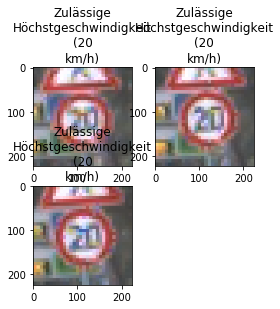

In [7]:
[print(im.shape) for im in images[0:2]]
images = preprocessing(images)
show_image(images[0:3],labels[0:3])

In [8]:
X = np.array(images)
y = np.array(labels)

In [9]:
print("shape train Image: ",X.shape)
print("shape train label: ",y.shape)

shape train Image:  (2150, 224, 224, 3)
shape train label:  (2150,)


In [10]:
# split to train_image,train_label and test_image,test_label
train_image, test_image, train_label, test_label = train_test_split(images, labels, test_size=0.25)
X_train,X_test,y_train, y_test = train_test_split(X, y, test_size=0.25)

In [11]:
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras.callbacks import (EarlyStopping,
                                               ModelCheckpoint,
                                               TensorBoard)
from tensorflow.python.keras import (losses,
                                     optimizers,
                                     metrics,
                                     regularizers)
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

# keras model VGGnet architektur 64->128->256->512-43
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(224,224, 3))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(4069, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(len(classe_label), activation='softmax'))

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3),
                 padding='same', activation='relu',
                 input_shape=(IMG_SIZE,IMG_SIZE, 3),
                 data_format="channels_last"))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(len(classe_label), activation='softmax'))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 55, 55, 128)       147584    
____

from tensorflow.keras.applications import VGG16
VGG16_model = VGG16(input_shape=(IMG_SIZE,IMG_SIZE, 3),
                   include_top = False,
                   weights='imagenet')
VGG16_model.trainable = False
global_average_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(len(classe_label),
                                         activation='softmax')
model_vgg16 = models.Sequential([
    VGG16_model,
    global_average_layer,
    prediction_layer
])
model_vgg16.summary()

In [21]:
loss = 'sparse_categorical_crossentropy'
metric = ["acc"]
lernrate = 1e-4
model.compile(loss=loss,
             optimizer=optimizers.RMSprop(lernrate),
             metrics=metric)


In [22]:
train_datagen = ImageDataGenerator(rescale=1./255,
                              rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

# print("train image shape :",train_image.shape)
print("train image shape from npArray :",X_train.shape)
# print("train label shape :",train_label.shape)
print("train label shape from npArray :",y_train.shape)
x = X_train[0].reshape((1,) + X_train[0].shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='test', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

from PIL import Image
import glob
for filename in glob.glob('preview/*.jpeg'):
    img = Image.open(filename)
    plt.imshow(img)
    plt.show()
    

In [23]:
train_generator = train_datagen.flow(X_train,y_train,batch_size=batch_size)
val_generator = val_datagen.flow(X_test,y_test,batch_size=batch_size)

In [ ]:
train_step_epoch = (len(X_train)+len(X_test))//batch_size
val_step_epoch = (len(y_train)+len(y_test))//batch_size
history = model.fit_generator(train_generator,
                              steps_per_epoch =train_step_epoch,
                              epochs=64,
                             validation_data=val_generator,
                              validation_steps=val_step_epoch
                             )

Epoch 1/64
33/33 [==============================] - 948s 29s/step - loss: 3.5863 - acc: 0.0468 - val_loss: 3.3449 - val_acc: 0.0490
Epoch 2/64
32/33 [============================>.] - ETA: 23s - loss: 3.0938 - acc: 0.1406